# Temperature Prediction on the Jena Weather Dataset

## Applied Machine Learning (ICS-5110) Coursework


In this Jupyter Notebook, we will implement a **random forest** algorithm from first principles and use it to predict the temperature on the [Jena Weather Dataset](https://www.kaggle.com/datasets/mnassrib/jena-climate). 

A **random forest** is an ensemble learning algorithm that combines multiple decision trees to make a final prediction. 

The **Jena Weather Dataset** consists of weather data from the city of Jena, Germany, collected over a period of several years. It contains measurements such as temperature, air pressure, and humidity, as well as information regarding the date and time of each measurement. 

Our task is to perform **temperature prediction**. We will use measurements not directly associated with the temperature to predict the temperature in degree Celsius at a specific date and time.

Besides training and testing our models, we will also determine the impact of some machine learning techniques on the performance of our model, including re-scaling and normalization, cross-validation, and feature selection. Additionally, we will also use Principal Component Analysis (PCA) to try to improve the precision of our model.

# Setup

## Global variables 

In this section we define global setup variables that will be used through the course of this notebook.

* **KAGGLE_USER** is a string that represents the user's Kaggle username, which is used to access the Kaggle API. This value can be taken from your `kaggle.json` authentication file.
* **KAGGLE_KEY** is a string that represents the user's Kaggle API key, which is used to access the Kaggle API. This value can be taken from your `kaggle.json` authentication file.
* **DROP_SET_THRESHOLD** is a number that represents the threshold for dropping a set of data from further analysis after feature selection.
* **PCA_THRESHOLD** is a number that represents the threshold for selecting the number of PCA components while iterating over the cumulative explained variance.
* **N_FOLDS** is a number that represents the number of folds to use in cross-validation, a technique used to evaluate the performance of a machine learning model.

To download your `kaggle.json` file from [Kaggle](http://kaggle.com/) and access the Kaggle API, follow these steps:

* Go to the Kaggle website and log in to your account.

* Click on your avatar in the top right corner of the page and select the "Account" option.

* Scroll down to the API section and click on the "Create New API Token" button. This will download the `kaggle.json` file to your computer.

In [ ]:
#@title Definition

KAGGLE_USER = 'ruanchaves93' #@param {type:"string"}
KAGGLE_KEY = '7bfda777d3fecae222a86d45e14359a5' #@param {type:"string"}
DROP_SET_THRESHOLD = 0.95 #@param {type:"number"}
PCA_THRESHOLD = 0.95 #@param {type:"number"}
N_FOLDS = 10 #@param {type:"number"} 

## Installation

Install code dependencies in quiet mode.

In [ ]:
!pip install kaggle -qqq


## Imports


Import relevant modules.

In [ ]:
import os
import json

import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from tqdm.notebook import tqdm

import numpy as np
from typing import List, Dict, Tuple, Union, Optional, Any

# Preprocessing

## Preliminary steps

### Load dataset

Load dataset from Kaggle.

In [ ]:
if not os.path.exists("~/.kaggle/kaggle.json"):
  with open("kaggle.json", "w+") as f:
    json.dump({"username": KAGGLE_USER,"key": KAGGLE_KEY}, f)
  !mkdir ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
if not os.path.exists("jena-climate.zip"):
  !kaggle datasets download mnassrib/jena-climate

if not os.path.exists("jena_climate_2009_2016.csv"):
  !unzip jena-climate.zip

 38% 5.00M/13.2M [00:00<00:00, 46.2MB/s]
100% 13.2M/13.2M [00:00<00:00, 87.7MB/s]
Archive:  jena-climate.zip
  inflating: jena_climate_2009_2016.csv  


In [ ]:
dataset = pd.read_csv("jena_climate_2009_2016.csv")
dataset = dataset.reset_index()

In [ ]:
dataset

,index,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8


### Drop temperature columns


The columns `"T (degC)"`, `"Tpot (K)"`, and `"Tdew (degC)"` represent the temperature in degrees Celsius, the potential temperature in Kelvin, and the dew point temperature in degrees Celsius, respectively. Since temperature can be represented in different units, these columns represent the same physical quantity (temperature).

Since these columns are redundant and represent the same thing as the `"T (degC)"` column, we must drop them from the dataset to avoid data leakage.

In [ ]:
dataset.drop("Tpot (K)", inplace=True, axis=1)
dataset.drop("Tdew (degC)", inplace=True, axis=1)

### Convert date and time strings

We define a function that converts date and time strings to timestamps, days of the year, and seconds since midnight. This will capture all three time factors that can affect the temperature at a given point: the date, the season, and the time of the day.

In [ ]:
def convert_to_timestamp(date):
  dt_object = datetime.strptime(date, '%d.%m.%Y %H:%M:%S')
  seconds_since_midnight = dt_object.hour * 60 * 60 + dt_object.minute * 60 + dt_object.second
  return dt_object.timestamp(), dt_object.timetuple().tm_yday, seconds_since_midnight

dataset[["timestamp", "year_day", "seconds"]] = list(dataset["Date Time"].apply(convert_to_timestamp))
dataset.drop("Date Time", inplace=True, axis=1)
dataset

,index,p (mbar),T (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg),timestamp,year_day,seconds
0,0,996.52,-8.02,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3,1.230769e+09,1.0,600.0
1,1,996.57,-8.41,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1,1.230769e+09,1.0,1200.0
2,2,996.53,-8.51,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6,1.230770e+09,1.0,1800.0
3,3,996.51,-8.31,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0,1.230770e+09,1.0,2400.0
4,4,996.51,-8.27,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3,1.230771e+09,1.0,3000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420546,420546,1000.07,-4.05,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0,1.483226e+09,366.0,84000.0
420547,420547,999.93,-3.35,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3,1.483227e+09,366.0,84600.0
420548,420548,999.82,-3.16,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2,1.483228e+09,366.0,85200.0
420549,420549,999.81,-4.23,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8,1.483228e+09,366.0,85800.0


### Define data splits


We split the data into two parts, one for training and development and one for testing. 

Then we use a `factory` to create a nested dictionary structure to store the data from the DataFrame, where the training and development data and the testing data are stored in different keys, and the raw data and processed data are stored in different subkeys. 

In [ ]:
from collections import defaultdict
import numpy as np

def factory(): return defaultdict(factory)

data = factory()

test = dataset.tail(int(len(dataset) * 0.2))
df = dataset.head(int(len(dataset) * 0.8))

test.drop("index", inplace=True, axis=1)
df.drop("index", inplace=True, axis=1)

data["test"]["raw"]["y"]["ndarray"] = test["T (degC)"].to_numpy()
data["test"]["raw"]["y"]["columns"] = list(test[["T (degC)"]].columns)

data["train+dev"]["raw"]["y"]["ndarray"] = df["T (degC)"].to_numpy()
data["train+dev"]["raw"]["y"]["columns"] = list(df[["T (degC)"]].columns)

df.drop("T (degC)", inplace=True, axis=1)
test.drop("T (degC)", inplace=True, axis=1)

df_X = df.to_numpy()
data["test"]["raw"]["x"]["ndarray"] = test.to_numpy()
data["test"]["raw"]["x"]["columns"] = list(test.columns)

data["train+dev"]["raw"]["x"]["ndarray"] = df.to_numpy()
data["train+dev"]["raw"]["x"]["columns"] = list(df.columns)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


### Visualize the splits


Here we define `visualize_data` that takes a dictionary as input and prints a representation of it in JSON format. The representation replaces the values of each key with the length of the value if it is not a string, and recursively processes nested dictionaries. The resulting dictionary is printed in JSON format.

In [ ]:
import yaml
import copy
import collections.abc
import json
import copy

def visualize_data(data: dict) -> str:
  """
  Visualizes the input data by returning a JSON representation of the data,
  where all non-string values are replaced by their lengths (if possible).
  """
  def get_repr(data: dict) -> dict:
    """
    Returns a copy of the input data where all non-string values are replaced
    by their lengths (if possible).
    """
    for key, value in data.items():
      if isinstance(value, dict):
        # Recursively apply the function to nested dictionaries.
        data[key] = get_repr(value)
      elif not isinstance(value, str):
        try:
          # Replace the value with its length if possible.
          data[key] = len(value)
        except TypeError:
          # Do nothing if the value is not a sequence (i.e., it doesn't have a length).
          pass
    return data
  # Return a JSON representation of the data.
  return json.dumps(get_repr(copy.deepcopy(data)), indent=4)


print(visualize_data(data))

{
    "test": {
        "raw": {
            "y": {
                "ndarray": 84110,
                "columns": 1
            },
            "x": {
                "ndarray": 84110,
                "columns": 14
            }
        }
    },
    "train+dev": {
        "raw": {
            "y": {
                "ndarray": 336440,
                "columns": 1
            },
            "x": {
                "ndarray": 336440,
                "columns": 14
            }
        }
    }
}


## Feature Selection



Feature selection is a technique used to identify and select only the most relevant features from a dataset. This is useful because it reduces the dimensionality of the input data, which can improve the performance of machine learning models. Here we will perform feature selection using the filter method and the Pearson correlation coefficient. 

Our implementation of the Pearson correlation coefficient can be described by the formula:

$$ \rho = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2 \sum_{i=1}^{n}(y_i - \bar{y})^2}} $$

Where $x$ and $y$ are the input arrays and $\bar{x}$ and $\bar{y}$ are the means of the input arrays.

By calculating the Pearson correlation coefficient between all pairs of features, we can identify those that are highly correlated and might not provide any additional useful information for our model. These highly correlated features can then be removed, reducing the dimensionality of the input data and improving the performance of the model.

In [ ]:
import numpy as np
def pearson_correlation(a: np.ndarray, b: np.ndarray) -> float:
    """
    Returns the Pearson correlation coefficient for the input arrays.
    
    Args:
        a: The first input array.
        b: The second input array.

    Returns:
        The Pearson correlation coefficient for the input arrays.
    """
    # Normalize the input arrays.
    norm_a = a - a.mean()
    norm_b = b - b.mean()
    # Compute the squared norms of the input arrays.
    squared_norm_a = norm_a ** 2
    squared_norm_b = norm_b ** 2
    # Compute the dot product of the normalized input arrays.
    dot_product_a_b = norm_a * norm_b
    # Compute the Pearson correlation coefficient.
    p_value = dot_product_a_b.sum() / np.sqrt(squared_norm_a.sum() * squared_norm_b.sum())
    return p_value

def get_corr_matrix(x: np.ndarray) -> np.ndarray:
  """
  Computes the Pearson correlation matrix for the input data.

  Args:
    x (np.ndarray): The input data for which to compute the correlation matrix.

  Return:
    np.ndarray: The Pearson correlation matrix for the input data.
  """
  # Initialize the correlation matrix with zeros.
  corr_matrix = np.zeros((x.shape[1], x.shape[1]))
  # Get the upper triangle indices of the correlation matrix.
  i_indices, j_indices = np.triu_indices(x.shape[1])
  # Transpose the input data. Each column will become a row.
  x_t = x.T
  for k in range(len(i_indices)):
    i = i_indices[k]
    j = j_indices[k]
    if i == j:
      # Skip the diagonal.
      continue
    # Get the ith and jth columns of the transposed input data.
    a = x_t[i]
    b = x_t[j]
    # Compute the Pearson correlation coefficient for the ith and jth columns.
    corr_matrix[i][j] = pearson_correlation(a,b)
  return corr_matrix

def get_drop_set(labels: List[str], corr_matrix: np.ndarray, threshold: float = 0.95) -> Tuple[List[str], List[int]]:
  """
  Returns the labels and indices of the columns in the input data that have a correlation coefficient
  greater than the specified threshold.

  Args:
      labels: A list of strings representing the labels of the columns in the input data.
      corr_matrix: A NumPy array representing the correlation matrix of the input data.
      threshold: A float representing the minimum absolute correlation coefficient that a column must have
          in order to be included in the output.

  Returns:
      A tuple containing two lists: the labels of the columns that have a correlation coefficient greater than
      the specified threshold, and the corresponding indices of those columns in the input data.
  """
  # Compute the absolute value of the correlation matrix.
  abs_corr_matrix = np.absolute(corr_matrix)
  # Zip the indices and values of the columns with a correlation coefficient greater than the threshold.
  drop_set = [(index, item) for index, item in enumerate(labels) if any(abs_corr_matrix[index] > threshold) ]
  # Unzip the list of tuples into two lists: the labels and the indices.
  drop_set_indices, drop_set_values = list(zip(*drop_set))
  return drop_set_values, drop_set_indices

In [ ]:
for dataset in data:
  raw_columns = data[dataset]["raw"]["x"]["columns"]
  raw_data = data[dataset]["raw"]["x"]["ndarray"]

  corr_matrix = get_corr_matrix(raw_data)
  drop_set_values, drop_set_indices = get_drop_set(raw_columns, corr_matrix, threshold=DROP_SET_THRESHOLD)
  print(f"Dropped columns for dataset {dataset}: {drop_set_values}")
  
  n_cols = data[dataset]["raw"]["x"]["ndarray"].shape[1]
  mask = np.ones(n_cols).astype(bool)
  mask[list(drop_set_indices)] = False
  
  data[dataset]["fs"]["x"]["ndarray"] = data[dataset]["raw"]["x"]["ndarray"][:, mask]
  data[dataset]["fs"]["x"]["columns"] = [x for x in raw_columns if x not in drop_set_values]

  data[dataset]["fs"]["y"] = data[dataset]["raw"]["y"]

Dropped columns for dataset test: ('VPact (mbar)', 'sh (g/kg)')
Dropped columns for dataset train+dev: ('VPact (mbar)', 'sh (g/kg)', 'wv (m/s)')


In [ ]:
print(visualize_data(data))

{
    "test": {
        "raw": {
            "y": {
                "ndarray": 84110,
                "columns": 1
            },
            "x": {
                "ndarray": 84110,
                "columns": 14
            }
        },
        "fs": {
            "x": {
                "ndarray": 84110,
                "columns": 12
            },
            "y": {
                "ndarray": 84110,
                "columns": 1
            }
        }
    },
    "train+dev": {
        "raw": {
            "y": {
                "ndarray": 336440,
                "columns": 1
            },
            "x": {
                "ndarray": 336440,
                "columns": 14
            }
        },
        "fs": {
            "x": {
                "ndarray": 336440,
                "columns": 11
            },
            "y": {
                "ndarray": 336440,
                "columns": 1
            }
        }
    }
}


## Rescaling and Normalization

Here we apply rescaling and normalization techniques to our training data. These preprocessing steps are essential for ensuring that the data is properly formatted and ready for principal component analysis (PCA), which we will perform in the next section.

The formulas for min-max scaling and mean normalization are implemented as follows:

$$\text{min max scaling}(arr) = \frac{arr - \text{min}(arr)}{\text{max}(arr) - \text{min}(arr)}$$

$$\text{mean normalisation}(arr) = \frac{arr - \text{mean}(arr)}{\text{max}(arr) - \text{min}(arr)}$$


In [ ]:
def min_max_scaled(arr: np.ndarray) -> np.ndarray:
  """Scales the elements of `arr` by their minimum and maximum values.
  
  This function scales the elements of a n-dimensional array `arr` by 
  the minimum and maximum values along each of its dimensions.
  
  Args:
    arr: The array to be scaled.
  
  Returns:
    A new array with the same shape as `arr`, with its elements scaled
    by their minimum and maximum values.
  """
  return (arr - arr.min(axis=0)) / (arr.max(axis=0) - arr.min(axis=0))

def mean_normalisation(arr: np.ndarray) -> np.ndarray:
  """Normalizes the elements of `arr` by their mean value.
  
  This function normalizes the elements of a n-dimensional array `arr` by
  the mean value along each of its dimensions.
  
  Args:
    arr: The array to be normalized.
  
  Returns:
    A new array with the same shape as `arr`, with its elements normalized
    by their mean value.
  """
  return (arr - arr.mean(axis=0)) / (arr.max(axis=0) - arr.min(axis=0))

def scale_and_normalize(arr: np.ndarray) -> np.ndarray:
  """Scales and normalizes the elements of `arr` by their minimum and maximum values.
  
  This function first scales the elements of `arr` by their minimum and maximum
  values, and then normalizes the scaled elements by their mean value.
  
  Args:
    arr: The array to be scaled and normalized.
  
  Returns:
    A new array with the same shape as `arr`, with its elements scaled
    and normalized as described above.
  """
  return mean_normalisation(min_max_scaled(arr))

In [ ]:
for dataset in data:
  raw_columns = data[dataset]["raw"]["x"]["columns"]
  raw_data = data[dataset]["raw"]["x"]["ndarray"]

  fs_columns = data[dataset]["fs"]["x"]["columns"]
  fs_data = data[dataset]["fs"]["x"]["ndarray"]

  data[dataset]["raw+norm"]["x"]["ndarray"] = scale_and_normalize(raw_data)
  data[dataset]["raw+norm"]["x"]["columns"] = raw_columns
  data[dataset]["raw+norm"]["y"] = data[dataset]["raw"]["y"]

  data[dataset]["fs+norm"]["x"]["ndarray"] = scale_and_normalize(fs_data)
  data[dataset]["fs+norm"]["x"]["columns"] = fs_columns
  data[dataset]["fs+norm"]["y"] = data[dataset]["fs"]["y"]

## PCA ( Principal Component Analysis )

PCA is a dimensionality reduction technique that can be used to reduce the number of features in a dataset while retaining as much of the original information as possible. 

The `PCA` class below takes a dataset as input and computes its covariance matrix, eigenvalues, and eigenvectors. In PCA, the eigenvectors of the covariance matrix are the principal components, and the eigenvalues are the corresponding variances along each principal component.

Our implementation of `PCA` provides two methods: `project`, which projects the dataset onto the principal components, and `determine_components`, which determines the number of principal components required to explain a given threshold of variance in the data. 

Although here we are using PCA to reduce the number of features in our dataset, like other dimensionality reduction algorithms ( e.g. t-SNE ), it can also be used for visualizing high-dimensional data in lower dimensions.

In [ ]:
class PCA(object):
    def __init__(self,X):
      """Perform Principal Component Analysis on a given dataset.

      Args:
        X: 2D numpy array of the dataset.

      Returns:
        None.
      """
      self.X = X
      self.covariance_matrix = np.cov(X, rowvar=False)
      eigenvalues, eigenvectors = np.linalg.eigh(self.covariance_matrix)
      sorted_tuples = sorted(list(zip(eigenvalues, eigenvectors)), key=lambda x: x[0], reverse=True)
      eigenvalues, eigenvectors = list(zip(*sorted_tuples))
      eigenvectors = np.array([np.array(x) for x in eigenvectors]) 
      self.eigenvalues = eigenvalues
      self.eigenvalues_sum = sum(eigenvalues)
      self.eigenvectors = eigenvectors
      self.explained_variance = [ (x / self.eigenvalues_sum) for x in self.eigenvalues]
      self.cumulative_explained_variance = np.cumsum(self.explained_variance)
  
    def project(self, components=2):
      """Projects the dataset onto the given number of principal components.

      Args:
        components: The number of principal components to project the data onto.
          Default is 2.

      Returns:
        The projected dataset.
      """
      projection_matrix = self.eigenvectors[:components, :]
      return self.X.dot(projection_matrix.T)

    def determine_components(self, threshold=0.95):
      """Determines the number of principal components required to explain the given threshold of variance.

      Args:
        threshold: The required threshold of variance that must be explained. Default is 0.95.

      Returns:
        The number of principal components required to explain the given threshold of variance.
      """
      for idx, item in enumerate(self.cumulative_explained_variance):
        if item >= threshold:
          return idx + 1

In [ ]:
norm_datasets = []
for split in data:
  for dataset in data[split]:
    if dataset.endswith("norm"):
      norm_datasets.append((split, dataset))

for split, dataset in norm_datasets:
    norm_data = data[split][dataset]["x"]["ndarray"]
    norm_columns = data[split][dataset]["x"]["columns"]

    pca = PCA(norm_data)
    components = pca.determine_components(threshold=PCA_THRESHOLD)
    print(f"Components for split {split}, dataset {dataset}: {components}")
    X_projection = pca.project(components=components)
    print(components, pca.cumulative_explained_variance)

    new_dataset = dataset + "+" + "pca"
    data[split][new_dataset]["x"]["ndarray"] = X_projection
    data[split][new_dataset]["x"]["columns"] = list(range(X_projection.shape[1]))
    data[split][new_dataset]["y"] = data[split][dataset]["y"]

Components for split test, dataset raw+norm: 6
6 [ 31.58781274  49.66264472  66.68421305  78.18730922  88.73666869
  96.34281104  99.25914009  99.81857313  99.91510517  99.99759056
  99.99976818  99.99999202  99.99999926 100.        ]
Components for split test, dataset fs+norm: 6
6 [ 27.25392509  47.49852102  63.75205282  76.98327012  89.21469085
  96.00075586  99.18535902  99.80457718  99.90187713  99.99744523
  99.99997217 100.        ]
Components for split train+dev, dataset raw+norm: 7
7 [ 24.46362852  43.71412782  60.62009025  74.716902    86.73961068
  94.37501135  97.91234351  99.33187092  99.79767129  99.91416987
  99.99983863  99.99999325  99.99999912 100.        ]
Components for split train+dev, dataset fs+norm: 6
6 [ 22.95945461  44.17176404  63.11676338  76.75772255  90.02241343
  95.72116246  98.06845165  99.39617961  99.88651188  99.99996881
 100.        ]


In [ ]:
print(visualize_data(data))

{
    "test": {
        "raw": {
            "y": {
                "ndarray": 84110,
                "columns": 1
            },
            "x": {
                "ndarray": 84110,
                "columns": 14
            }
        },
        "fs": {
            "x": {
                "ndarray": 84110,
                "columns": 12
            },
            "y": {
                "ndarray": 84110,
                "columns": 1
            }
        },
        "raw+norm": {
            "x": {
                "ndarray": 84110,
                "columns": 14
            },
            "y": {
                "ndarray": 84110,
                "columns": 1
            }
        },
        "fs+norm": {
            "x": {
                "ndarray": 84110,
                "columns": 12
            },
            "y": {
                "ndarray": 84110,
                "columns": 1
            }
        },
        "raw+norm+pca": {
            "x": {
                "ndarray": 84110,
         

## K-Fold Cross Validation


Here we implement **k-fold cross validation**. The original dataset is divided into k subsets, and the model is trained and evaluated k times in a leave-one-out fashion. 

Each time, one subset is used as the test set and the other subsets are used as the training set. Next we take statistical measurements over the performance across all k trials. 

Although our dataset is not particularly small, k-fold cross validation will help us to portray a more accurate estimate of the model's performance. 

In [ ]:
import itertools
def generate_folds(X, k=10):
  """Generates k folds for cross-validation.

  Args:
    X: The dataset.
    k: The number of folds to generate.

  Returns:
    A tuple containing the train and dev datasets for each fold.
  """
  folds = []
  # The variable remainder is used to ensure that the folds of the dataset 
  # are evenly distributed and that no data is lost.
  remainder = len(X) % k
  step = len(X) // k
  start_pointer = 0
  next_step = step
  # Generate the folds.
  while start_pointer + next_step < len(X):
    if remainder:
      next_step += 1
      remainder -= 1
      folds.append(X[start_pointer:start_pointer+next_step])
      next_step -= 1
    else:
      folds.append(X[start_pointer:start_pointer+next_step])
    start_pointer += next_step
  # Generate the train and dev datasets for each fold.
  for idx in range(len(folds)):
    # The train dataset is the concatenation of all folds except the current fold.
    train = folds[0:idx] + folds[idx+1:len(folds)]
    train = np.array([x for y in train for x in y])
    train = np.array(train, dtype=np.float64)
    # The dev dataset is the current fold.
    dev = np.array(folds[idx], dtype=np.float64)
    yield train, dev

def get_all_folds(x, y, k=10):
  """Generates k folds for cross-validation for a dataset with features and labels.

  Args:
    x: The features of the dataset.
    y: The labels of the dataset.
    k: The number of folds to generate.

  Returns:
    A tuple containing the train features, train labels, dev features, and dev labels for each fold.
  """
  data = []
  # Concatenate the features and labels into a single dataset.
  x_y = np.append(x, y.reshape(-1, 1), axis=1)
  # Generate the train and dev datasets for each fold.
  for train, dev in generate_folds(x_y, k=k):
    # Split the train dataset into features and labels.
    train_x = np.delete(train, -1, axis=1)
    train_y = train[:, -1]
    # Split the dev dataset into features and labels.
    dev_x = np.delete(dev, -1, axis=1)
    dev_y = dev[:, -1]
    yield train_x, train_y, dev_x, dev_y

cross_validation_data = factory()
for split in data:
  for dataset in data[split]:
    x = data[split][dataset]["x"]["ndarray"]
    y = data[split][dataset]["y"]["ndarray"]
    x_cols = data[split][dataset]["x"]["columns"]
    y_cols = data[split][dataset]["y"]["columns"] 
    for idx, (train_x, train_y, dev_x, dev_y) in enumerate(get_all_folds(x, y, k=N_FOLDS)):
      cross_validation_data[split][dataset][idx]["train"]["x"]["ndarray"] = train_x
      cross_validation_data[split][dataset][idx]["train"]["x"]["columns"] = x_cols
      cross_validation_data[split][dataset][idx]["train"]["y"]["ndarray"] = train_y
      cross_validation_data[split][dataset][idx]["train"]["y"]["columns"] = y_cols

      cross_validation_data[split][dataset][idx]["validation"]["x"]["ndarray"] = dev_x
      cross_validation_data[split][dataset][idx]["validation"]["x"]["columns"] = x_cols
      cross_validation_data[split][dataset][idx]["validation"]["y"]["ndarray"] = dev_y
      cross_validation_data[split][dataset][idx]["validation"]["y"]["columns"] = y_cols

# Training and evaluation with `sklearn`

In this section we will define evaluation metrics and evaluation functions for our models. Furthermore, we will evaluate an out-of-the-box random forest model from the `sklearn` library.

## Define evaluation metrics

In this section we define appropriate evaluation metrics for the problem of temperature prediction, which is a regression task. We will utilize the **mean squared error metric** as a measure of the difference between the predicted values and the true values.

The pearson correlation coefficient is not an entirely appropriate metric for evaluating regression models because, as it is a measure of the strength of a linear relationship between two variables, there are some edge cases where it can fail to accurately measure the performance of our model. However, we  include it in our evaluation for the sake of completeness.

Our implementation of the MSE metric can be defined by the formula:

$$\text{mean_squared_error}(a, b) = \frac{\sum_{i=1}^{n} (a_i - b_i)^2}{n}$$

where $a$ and $b$ are arrays of values and $n$ is the length of the arrays. 

In [ ]:
def mean_squared_error(a: np.ndarray, b: np.ndarray) -> float:
  """
  Calculates the mean squared error between two arrays of values.
  
  Args:
    a: the first array
    b: the second array
  
  Returns:
    The mean squared error between `a` and `b`.
  """
  return np.mean((a - b) ** 2)

def evaluate_regression(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
  """
  Evaluates the regression performance of a model by calculating the mean squared error (MSE) 
  and Pearson correlation coefficient between the true and predicted values.
  
  Args:
    y_true: the true values
    y_pred: the predicted values
  
  Returns:
    A dictionary containing the MSE and Pearson correlation coefficient between `y_true` and `y_pred`.
  """
  return {
      "mse": mean_squared_error(y_true, y_pred),
      "pearson": pearson_correlation(y_true, y_pred)
  }

def generate_cross_validation_chart(metrics: dict) -> pd.DataFrame:
  """
  Generates a Pandas DataFrame containing the mean, standard deviation, 
  and median of the MSE and Pearson correlation coefficients calculated in `evaluate_regression()`.
  
  Args:
    metrics: a dictionary containing the MSE and Pearson correlation coefficients for a number of cross-validation folds.
  
  Returns:
    A Pandas DataFrame containing the mean, standard deviation, and median of the MSE and Pearson correlation coefficients.
  """
  return pd.DataFrame(metrics).agg(
      {
          "mse": ["mean", "std", "median"], 
          "pearson": ["mean", "std", "median"]})

## Evaluation functions

In [ ]:
def test_model(model, data: Dict[str, Any], metadata: Dict[str, Any], 
               train_split: str="train+dev", test_split: str="test", 
               dataset: str="raw", sample: int=None) -> Dict[str, Any]:
  """Tests the model on a dataset and returns the evaluation metrics and predictions.

  Args:
    model: The model to test. The model should be wrapped inside an anonymous function.
    data: A dictionary containing the data to use for testing.
    metadata: A dictionary containing metadata about the data.
    train_split: The name of the train split to use. Defaults to "train+dev".
    test_split: The name of the test split to use. Defaults to "test".
    dataset: The name of the dataset to use. Defaults to "raw".
    sample: The number of samples to use for testing. Defaults to None, which means use all samples.

  Returns:
    A dictionary containing the evaluation metrics, predictions, and labels.
  """
  df = []
  iterator = []

  train_X = data[train_split][dataset]["x"]["ndarray"]
  train_Y = data[train_split][dataset]["y"]["ndarray"]

  test_X = data[test_split][dataset]["x"]["ndarray"]
  test_Y = data[test_split][dataset]["y"]["ndarray"]

  # If a sample size is provided, use it to subsample the data
  if sample:
    get_sample = lambda a: a[range(0, len(a), len(a) // sample)]
    train_X = get_sample(train_X)
    train_Y = get_sample(train_Y)

  # Create and fit the model
  regr = model()
  regr.fit(train_X, train_Y)
  # Make predictions on the test data
  pred = regr.predict(test_X)
  # Evaluate the model using the evaluate_regression function
  m = evaluate_regression(test_Y, pred)

  # Return the evaluation metrics, predictions, and labels
  return {
      "metrics": m,
      "predictions": pred,
      "labels": test_Y
  }

def evaluate_cross_validation(model, cross_validation_data: Dict[str, Any], metadata: Dict[str, Any]):
  """Evaluates the model using cross-validation.

  Args:
    model: The model to evaluate.
    cross_validation_data: A dictionary containing the cross-validation data.
    metadata: A dictionary containing metadata about the model.

  Returns:
    A pandas DataFrame containing the evaluation metrics for each split and dataset.
  """
  df = []
  iterator = []
  # Create an iterator that will iterate over all splits, datasets, and indices
  for split in cross_validation_data:
    for dataset in cross_validation_data[split]:
      for idx in cross_validation_data[split][dataset]:
        iterator.append((split, dataset, idx))
  
  for split, dataset, idx in tqdm(iterator):
    d = cross_validation_data[split][dataset][idx]
    
    # Get train and validation data
    train_X = d["train"]["x"]["ndarray"]
    train_Y = d["train"]["y"]["ndarray"]
    validation_X = d["validation"]["x"]["ndarray"]
    validation_Y = d["validation"]["y"]["ndarray"]
    
    # Train the model
    regr = model()
    regr.fit(train_X, train_Y)

    # Evaluate the model
    pred = regr.predict(validation_X)
    m = evaluate_regression(validation_Y, pred)
    mse = m["mse"]
    pearson = m["pearson"]

    # Save the results
    row = {
        "split": split,
        "dataset": dataset,
        "idx": idx,
        "mse": mse,
        "pearson": pearson
    }
    row.update(metadata)
    df.append(row)

  return pd.DataFrame(df)

## Evaluate with k-fold cross-validation

### Execution

In this section we will perform a preliminary evaluation of an out-of-the box implementation of Random Forests by `sklearn`. We will evaluate it on our dataset under a few distinct scenarios:

* **raw**: the original training data.
* **fs+norm**: the training data after feature selection and normalisation.
* **fs+norm+pca**: the training data after feature selection, normalisation and PCA.
* **raw+norm**: the training data after normalisation.
* **raw+norm+pca**: the training data after normalisation and PCA.

In [ ]:
metadata = dict(max_depth=2, random_state=0, n_estimators = 100, n_jobs=-1)
get_random_forest = lambda: RandomForestRegressor(**metadata)
cross_validation_metrics_df = evaluate_cross_validation(get_random_forest, cross_validation_data, metadata)
cross_validation_metrics_df

  0%|          | 0/108 [00:00<?, ?it/s]

,split,dataset,idx,mse,pearson,max_depth,random_state,n_estimators,n_jobs
0,test,raw,0,8.669006,0.879815,2,0,100,-1
1,test,raw,1,8.186680,0.879033,2,0,100,-1
2,test,raw,2,4.474678,0.913447,2,0,100,-1
3,test,raw,3,6.036919,0.856872,2,0,100,-1
4,test,raw,4,14.492135,0.686612,2,0,100,-1
...,...,...,...,...,...,...,...,...,...
103,train+dev,fs+norm+pca,4,18.374530,0.867743,2,0,100,-1
104,train+dev,fs+norm+pca,5,10.644366,0.888707,2,0,100,-1
105,train+dev,fs+norm+pca,6,11.296180,0.901252,2,0,100,-1
106,train+dev,fs+norm+pca,7,11.652094,0.918097,2,0,100,-1


In [ ]:
cross_validation_metrics_df.to_csv("cross_validation_metrics.csv")

In [ ]:
mask = cross_validation_metrics_df["split"] == "train+dev"
final_metrics_df = cross_validation_metrics_df[mask][["dataset", "mse", "pearson"]].groupby(by=["dataset"]).agg(
      {
          "mse": ["mean", "std", "median"],
          "pearson": ["mean", "std", "median"]}).round(3)

### Results

It is clear from the measurements on mean squared error columns that PCA had a negative effect on the performance of our model. In contrast, steps such as feature selection and normalization had little impact on the model's performance. This is because decision trees, which are used in random forests, only consider one feature at a time when making a decision. This allows decision trees and random forests to perform well even when the features have different scales and distributions.



In [ ]:

final_metrics_df

mse                pearson              
                mean    std  median    mean    std median
dataset                                                  
fs             8.388  1.419   8.039   0.930  0.015  0.929
fs+norm        8.388  1.419   8.039   0.930  0.015  0.929
fs+norm+pca   13.203  2.922  11.652   0.894  0.021  0.897
raw            8.388  1.419   8.039   0.930  0.015  0.929
raw+norm       8.388  1.419   8.039   0.930  0.015  0.929
raw+norm+pca  14.410  2.012  13.620   0.883  0.022  0.885

In [ ]:
print(final_metrics_df.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} & \multicolumn{3}{l}{mse} & \multicolumn{3}{l}{pearson} \\
{} &    mean &    std &  median &    mean &    std & median \\
dataset      &         &        &         &         &        &        \\
\midrule
fs           &   8.388 &  1.419 &   8.039 &   0.930 &  0.015 &  0.929 \\
fs+norm      &   8.388 &  1.419 &   8.039 &   0.930 &  0.015 &  0.929 \\
fs+norm+pca  &  13.203 &  2.922 &  11.652 &   0.894 &  0.021 &  0.897 \\
raw          &   8.388 &  1.419 &   8.039 &   0.930 &  0.015 &  0.929 \\
raw+norm     &   8.388 &  1.419 &   8.039 &   0.930 &  0.015 &  0.929 \\
raw+norm+pca &  14.410 &  2.012 &  13.620 &   0.883 &  0.022 &  0.885 \\
\bottomrule
\end{tabular}



## Testing

In this section we evaluate an out-of-the box implementation of Random Forests on our test set.

The random forest implementation by `sklearn` was able to reach a mean squared error of **8.156219060725725** on our test set.

In [ ]:
metadata = dict(max_depth=2, random_state=0, n_estimators = 100, n_jobs=-1)
get_random_forest = lambda: RandomForestRegressor(**metadata)
output = test_model(get_random_forest, data, metadata, train_split="train+dev", test_split="test", dataset="raw")
output

{'metrics': {'mse': 8.156219060725725, 'pearson': 0.9364745281700044},
 'predictions': array([21.27075823, 19.52783326, 12.98694785, ..., -3.29976245,
        -3.29976245, -3.29976245]),
 'labels': array([17.36, 17.15, 16.92, ..., -3.16, -4.23, -4.82])}

In [ ]:
output["metrics"]

{'mse': 8.156219060725725, 'pearson': 0.9364745281700044}

## Visualization

At the end of this section, we produce a visualization of our predictions and put them side by side with the actual temperatures.

### Code

In [ ]:
import math
import seaborn as sns
def reshape_1d_array_with_padding(arr: np.ndarray, wrap: int=500) -> np.ndarray:
  """Reshape a 1D numpy array by adding padding to the end so that its length is a multiple of `wrap`.
  
  Args:
      arr (np.ndarray): The 1D array to be reshaped.
      wrap (int): The length of the subarrays that the reshaped array will be split into.
  
  Returns:
      np.ndarray: The reshaped array, with padding added to the end.
  """

  # Get the length of the original array
  old_len = arr.shape[0]

  # Calculate the length of the reshaped array
  new_len = wrap * math.ceil(old_len / wrap)
  
  # Add padding to the end of the array
  padded_arr = np.pad(arr, (0, new_len - old_len), 'constant')
  
  # Reshape the array into subarrays of length `wrap`
  padded_arr = padded_arr.reshape((-1, wrap))
  
  # Return the transpose of the reshaped array
  return padded_arr.T

In [ ]:
def plot_results(output: Dict[str, Any]) -> None:
  """
  Plots heatmaps of the given labels and predictions using seaborn.

  Args:
    output (dict): a dictionary containing "labels" and "predictions" keys
      whose values are 2-dimensional arrays to be plotted as heatmaps.

  Returns:
    None
  """
  plt.rcParams['figure.figsize'] = [15, 5]
  fig = plt.figure()
  fig.subplots_adjust(hspace=0.1, wspace=0.1)
  ax = fig.add_subplot(1, 2, 1)
  fig_1 = sns.heatmap(reshape_1d_array_with_padding(output["labels"].copy()), cmap="coolwarm", vmin=min(output["labels"]), vmax=max(output["labels"]), cbar=False)
  fig_1.axis('off')
  ax = fig.add_subplot(1, 2, 2)
  fig_2 = sns.heatmap(reshape_1d_array_with_padding(output["predictions"].copy()), cmap="coolwarm", vmin=min(output["labels"]), vmax=max(output["labels"]), cbar=False)
  fig_2.axis('off')

### Plot

The figure on the left shows the original temperatures over time. The figure on the right shows our temperature predictions for the same time frame. In the both figures, the summer season is represented by a pink band with bright red strips, while the other seasons appear in distinct shades of blue. 

If the right figure were exactly the same as the left figure, it would mean that we had produced a perfect model.

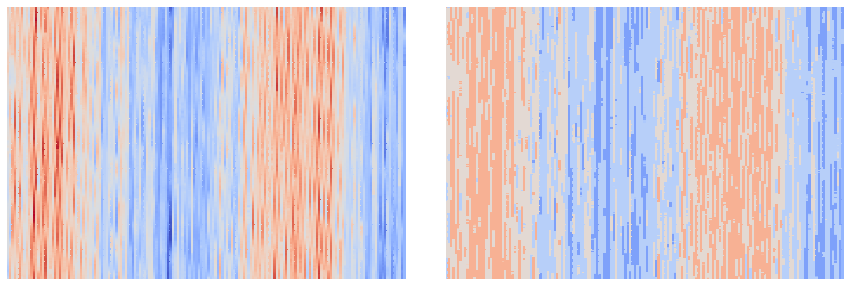

In [ ]:
plot_results(output)

# Model development

In this section we will develop and evaluate our own Random Forest model. We will start by implementing its building blocks, the decision trees.

## Decision Trees

Decision trees learn to make predictions by recursively partitioning the data into smaller and smaller subsets based on a decision rule. We use the following formula to determine the best decision rule at each node:

$$\text{get_mse}(left, right) = \frac{|left|}{|left| + |right|} \times \text{MSE}(left, \text{mean}(left)) + \frac{|right|}{|left| + |right|} \times \text{MSE}(right, \text{mean}(right))$$

where $left$ and $right$ are arrays containing the values of the left and right partitions at each step, and $\text{MSE}$ is a function that computes the mean squared error between two arrays.

At each step, we decide on the best feature and the best pivot by choosing the option that minimizes the output of `get_mse(left, right)`.   

After the training stage, decision rules will have been defined for each node. Then predictions will be made by traversing the tree in a top-down fashion until a leaf node is reached. 

The predicted value will be the average of the values stored at the leaf node reached by the input vector.

In [ ]:
class DecisionTree:
    def __init__(self, x, y, row_indexes, minimum_leaf_size=5, depth = 0, max_depth=2):
        """Initialize a DecisionTree instance.

        Args:
            x: A numpy array of shape (n_samples, n_features) representing the training data
            y: A numpy array of shape (n_samples,) representing the target values
            row_indexes: A numpy array of shape (n_samples,) representing the indices of the rows of x and y to use for training this node
            minimum_leaf_size: The minimum number of samples that must be present in a leaf node
            depth: The current depth of this node in the decision tree
            max_depth: The maximum depth of the decision tree
        """
        self.x = x 
        self.y = y
        self.row_indexes = row_indexes
        self.minimum_leaf_size = minimum_leaf_size
        self.prediction = np.mean(y[row_indexes])
        self.mse = float('inf')
        self.depth = depth
        self.max_depth = max_depth
        self.left = None
        self.right = None
        self.chosen_column_index = None
        self.generate_children()

    def update_pivot(self):
      """Update the pivot value and chosen column index for the decision rule at this node.
      
      The pivot value and chosen column index are determined by finding the split that minimizes the mean squared error.
      """
      for column_index in range(self.x.shape[1]):
        mse, pivot = self.get_pivot(column_index)
        if mse < self.mse:
          self.mse = mse
          self.pivot = pivot
          self.chosen_column_index = column_index

    def generate_children(self):
        """Generate child nodes for this node.

        If the current depth is equal to the maximum depth of the tree, or if the current node is a leaf,
        no child nodes are generated. Otherwise, child nodes are generated by splitting the data at the pivot value determined by 
        the `update_pivot` method.
        """
        if self.depth == self.max_depth:
          return
        
        self.update_pivot()

        if self.mse == float('inf'):
          return
        
        x = self.x[self.row_indexes, self.chosen_column_index]
        left_indexes_mask = x <= self.pivot
        right_indexes_mask = x > self.pivot

        self.left = DecisionTree(self.x, self.y, self.row_indexes[left_indexes_mask], 
                                    depth = self.depth + 1,
                                    max_depth = self.max_depth,
                                    minimum_leaf_size=self.minimum_leaf_size)
        self.right = DecisionTree(self.x, self.y, self.row_indexes[right_indexes_mask], 
                                    depth = self.depth + 1,
                                    max_depth = self.max_depth,
                                    minimum_leaf_size=self.minimum_leaf_size)
        
    def get_pivot(self, column_index: int) -> Tuple[float, Optional[float]]:
        """
        Gets the pivot value for the given column index that minimizes the mean squared error.
        
        Args:
            column_index (int): The column index to compute the pivot for.

        Returns:
            Tuple[float, Optional[float]]: The minimum mean squared error and the pivot value, 
            or (float('inf'), None) if no valid pivot value was found.
        """
        x = self.x[self.row_indexes, column_index]
        y = self.y[self.row_indexes]
        unique_values = np.unique(x)
        min_mse = float('inf')
        pivot = None
        for value in unique_values:
            left_indexes_mask = x <= value
            right_indexes_mask = x > value
            if left_indexes_mask.sum() < self.minimum_leaf_size or right_indexes_mask.sum() < self.minimum_leaf_size:
              continue
            mse = self.get_mse(y[left_indexes_mask], y[right_indexes_mask])
            if mse < min_mse:
              min_mse = mse
              pivot = value
        return min_mse, pivot

    def get_mse(self, left, right):
        """
        This method computes the weight-averaged mean squared error of a pair of numpy arrays.

        Args:
            left: A 1D NumPy array containing the values of the left pair.
            right: A 1D NumPy array containing the values of the right pair.

        Returns:
            A float representing the weight-averaged mean squared error.
        """
        l_mean = left.mean()
        r_mean = right.mean()
        l_percent = len(left) / (len(right) + len(left))
        r_percent = len(right) / (len(right) + len(left))
        return l_percent * mean_squared_error(left, l_mean) + r_percent * mean_squared_error(right, r_mean)

    def predict(self, x):
        """
        Predicts the target variable for each row of the input data.

        Args:
            x: A 2D NumPy array containing the data for all the features.

        Returns:
            A 1D NumPy array containing the predicted values for the target variable.
        """
        return np.array([self.predict_row(row) for row in x])

    def predict_row(self, row):
        """
        Predicts the value of the target variable for a single row of data.

        Args:
            row: A 1D NumPy array containing the data for all the features of a single row.

        Returns:
            A float representing the predicted value of the target variable.
        """
        if not (self.left and self.right):
          return self.prediction
        if row[self.chosen_column_index] <= self.pivot:
          return self.left.predict_row(row)
        else:
          return self.right.predict_row(row)

## Random Forests

Here we implement the random forest algorithm. Random forests are an ensemble learning method that uses decision trees, referred to as *estimators*, to make predictions. Although decision trees individually have low bias and high variance, a better compromise is reached when several instances are used in a single ensemble.

Using the bagging method, our random forest generates bootstrapped samples of the training data by randomly sampling the input data with replacement. 

The `fit` method fits the random forest to the training data by training a decision tree on each bootstrapped sample of the data and storing the trained trees in the `self.trees` list.

The `predict` method will use the trees in `self.trees` to make predictions on a new dataset by averaging the predictions made by each individual tree.

In [ ]:
from multiprocessing import Pool
from tqdm.notebook import tqdm

def get_decision_tree(x, y, length, max_depth, min_samples_leaf):
  """
  This function creates a new decision tree instance with the given data and settings.
  
  Args:
    x: An array of input data to use for building the decision tree.
    y: An array of target values corresponding to the input data.
    length: The length of the input data arrays.
    max_depth: The maximum depth of the decision tree.
    min_samples_leaf: The minimum number of samples required to be a leaf node.
  
  Returns:
    A DecisionTree instance with the given data and settings.
  """
  # Create a new decision tree instance with the given data and settings.
  return DecisionTree(x, y, np.arange(len(y)), 
                                         max_depth=max_depth,
                                         minimum_leaf_size=min_samples_leaf)

def get_decision_tree_list(
    x_bags: List[List[int]],
    y_bags: List[List[int]],
    length: int,
    max_depth: int,
    min_samples_leaf: int,
    parallel: bool = False,
    n_jobs: int = 10
) -> List[DecisionTree]:
  """Returns a list of decision trees for the given x and y data, length, max depth, and minimum leaf size.
  
  Args:
    x_bags: A list of lists of x data for each decision tree.
    y_bags: A list of lists of y data for each decision tree.
    length: The length of the x and y data.
    max_depth: The maximum depth of the decision trees.
    min_samples_leaf: The minimum number of samples in a leaf node of the decision trees.
    parallel: Whether to generate the trees in parallel or not. Defaults to False.
    n_jobs: The number of jobs to use if generating the trees in parallel. Defaults to 10.
  
  Returns:
    A list of DecisionTree objects.
  """
  iterable = []
  # Create a list of tuples with the input data for each decision tree.
  for idx in range(len(x_bags)):
    row = iterable.append((x_bags[idx], y_bags[idx], length, max_depth, min_samples_leaf),)
  # If running in parallel, use a pool of workers to generate the decision trees.
  if parallel:
    with Pool(n_jobs) as pool:
      output = pool.starmap(get_decision_tree, iterable)
  # Otherwise, generate the trees sequentially.
  else:
    output = []
    for tup in tqdm(iterable):
      output.append(get_decision_tree(*tup))
  return output


class RandomForest:
    
    def __init__(self, n_estimators: int = 10, min_samples_leaf: int = 2, max_depth: int = 2):
        """A random forest classifier.

        A random forest is an ensemble of decision trees, where each decision tree is trained on a bootstrapped sample of the
        training data. The predictions made by each tree are then averaged to make the final prediction.

        Args:
            n_estimators (int): The number of decision trees in the random forest. Defaults to 10.
            min_samples_leaf (int): The minimum number of samples required to be at a leaf node. Defaults to 2.
            max_depth (int): The maximum depth of each decision tree. Defaults to 2.
        """
        self.n_estimators = n_estimators
        self.min_samples_leaf = min_samples_leaf
        self.max_depth = max_depth
        self.trees = []
    
    def bagging(self, x: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """
        Generate a bootstrapped sample of the training data.

        Args:
            x (np.ndarray): The training features.
            y (np.ndarray): The training labels.

        Returns:
            Tuple[np.ndarray, np.ndarray]: A tuple containing the bootstrapped features and labels.
        """
        indexes = np.random.choice(range(x.shape[0]), x.shape[0], replace=True)
        return x[indexes], y[indexes]

    def fit(self, x: np.ndarray, y: np.ndarray) -> None:
        """
        Fit the random forest to the training data.

        For each estimator in `self.n_estimators`, this method generates a bootstrapped sample of the training data and
        trains a decision tree on that sample. The trained decision trees are then stored in `self.trees`.

        Args:
            x (np.ndarray): The training features.
            y (np.ndarray): The training labels.
        """
        x_bags, y_bags = list(zip(*[self.bagging(x,y) for _ in range(self.n_estimators)]))
        self.trees = get_decision_tree_list(
            x_bags, y_bags, np.arange(len(y_bags)), 
            self.max_depth, self.min_samples_leaf)

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Make predictions using the random forest.

        Args:
            X (np.ndarray): The test features.

        Returns:
            np.ndarray: An array of predicted labels.
        """
        return np.array([tree.predict(X) for tree in self.trees]).mean(axis=0)

# Model evaluation

## MSE

Our implementation of random forests was able to reach a mean squared error of **6.540878849885322**.   

This is notably better than the previous MSE reached by the `sklean` solution under similar hyperparameters, at **8.156219060725725**

In [ ]:
metadata = dict()
get_random_forest = lambda: RandomForest(**metadata)
output = test_model(get_random_forest, data, metadata, train_split="train+dev", test_split="test", dataset="raw", sample=1000)
output

  0%|          | 0/10 [00:00<?, ?it/s]

{'metrics': {'mse': 6.540878849885322, 'pearson': 0.9493407776665573},
 'predictions': array([19.68406355, 17.13943299, 14.57436529, ..., -3.0969508 ,
        -3.0969508 , -3.0969508 ]),
 'labels': array([17.36, 17.15, 16.92, ..., -3.16, -4.23, -4.82])}

## Visualization

The figure on the left shows the original temperatures over time. The figure on the right shows our temperature predictions for the same time frame. In the both figures, the summer season is represented by a pink band with bright red strips, while the other seasons appear in distinct shades of blue. 

If the right figure were exactly the same as the left figure, it would mean that we had produced a perfect model.

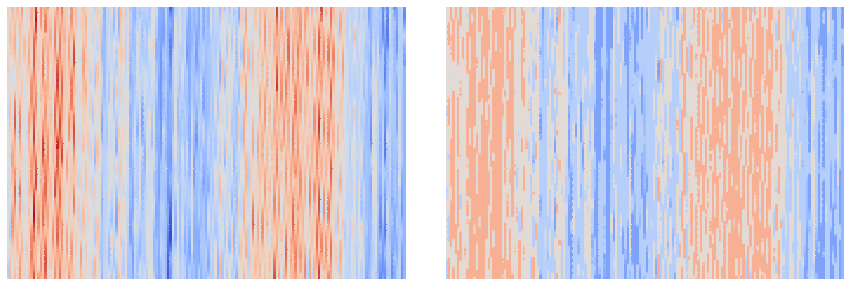

In [ ]:
plot_results(output)

# Hyperparameter Optimization

Although our results are similar to the actual temperatures, they are still not entirely satisfactory. We will investigate if they can be improved through hyperparameter optimization of our model. 

We will investigate three distinct hyperparameters: sample size, maximum tree depth and number of estimators.

## Sample size

Our results indicate that it is not beneficial to increase sample size above 100 for shallow decision trees ( with maximum depth less or equal to two ). The mean squared error starts to increase with sample size for samples larger than 100 records.

### Experiments

In [ ]:
sample_size_df = []
for sample_size in [10, 50, 100, 500, 1000, 5000, 10000]:
  output = test_model(get_random_forest, data, metadata, train_split="train+dev", test_split="test", dataset="raw", sample=sample_size)
  sample_size_df.append(output["metrics"])

sample_size_df = pd.DataFrame(sample_size_df)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
sample_size_df["sample_size"] = [10, 50, 100, 500, 1000, 5000, 10000]
sample_size_df

,mse,pearson,sample_size
0,43.629160,0.813232,10
1,11.201683,0.934969,50
2,5.172602,0.961321,100
3,6.165437,0.954453,500
4,6.628989,0.948636,1000
5,7.477602,0.942064,5000
6,7.775493,0.939647,10000


In [ ]:
print(sample_size_df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &        mse &   pearson \\
\midrule
0 &  43.629160 &  0.813232 \\
1 &  11.201683 &  0.934969 \\
2 &   5.172602 &  0.961321 \\
3 &   6.165437 &  0.954453 \\
4 &   6.628989 &  0.948636 \\
5 &   7.477602 &  0.942064 \\
6 &   7.775493 &  0.939647 \\
\bottomrule
\end{tabular}



### Plot

Text(0.5, 1.0, 'Mean squared error and sample size (maximum depth = 2)')

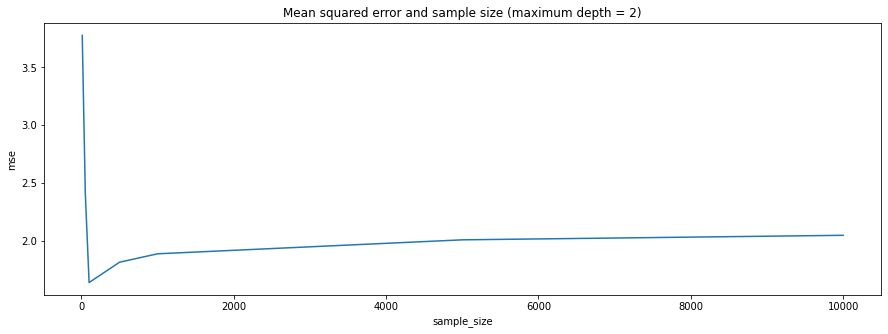

In [ ]:
sample_size_df_log = copy.deepcopy(sample_size_df)
sample_size_df_log["mse"] = sample_size_df_log["mse"].apply(lambda x: math.log(x))
fig_sample_size_2 = sns.lineplot(data=sample_size_df_log, x="sample_size", y="mse")
fig_sample_size_2.set_title("Mean squared error and sample size (maximum depth = 2)")

## Maximum tree depth

We can use larger sample sizes to improve our model if we allow our estimators to go deeper. In fact, the MSE improves by two orders of magnitude after allowing a larger maximum tree depth. 

### Experiments

In [ ]:
output = test_model(get_random_forest, data, metadata, train_split="train+dev", test_split="test", dataset="raw", sample=100)
sample_size_df.append(output["metrics"])

In [ ]:
max_depth_df = []
for curr_max_depth in [2, 4, 8, 16]:
  for sample_size in [100, 1000]:
    metadata = dict(max_depth=curr_max_depth)
    get_random_forest = lambda: RandomForest(**metadata)
    output = test_model(get_random_forest, data, metadata, train_split="train+dev", test_split="test", dataset="raw", sample=sample_size)
    row = output["metrics"]
    row.update({"max_depth": curr_max_depth, "sample_size": sample_size})
    max_depth_df.append(row)

max_depth_df = pd.DataFrame(max_depth_df)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
max_depth_df

,mse,pearson,max_depth,sample_size
0,7.079283,0.949622,2,100
1,6.730847,0.947804,2,1000
2,2.496200,0.984564,4,100
3,0.241197,0.998173,4,1000
4,1.829748,0.987537,8,100
5,0.074910,0.999509,8,1000
6,1.923439,0.987008,16,100
7,0.070732,0.999504,16,1000


In [ ]:
print(max_depth_df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &       mse &   pearson &  max\_depth &  sample\_size \\
\midrule
0 &  7.079283 &  0.949622 &          2 &          100 \\
1 &  6.730847 &  0.947804 &          2 &         1000 \\
2 &  2.496200 &  0.984564 &          4 &          100 \\
3 &  0.241197 &  0.998173 &          4 &         1000 \\
4 &  1.829748 &  0.987537 &          8 &          100 \\
5 &  0.074910 &  0.999509 &          8 &         1000 \\
6 &  1.923439 &  0.987008 &         16 &          100 \\
7 &  0.070732 &  0.999504 &         16 &         1000 \\
\bottomrule
\end{tabular}



### Plot

Text(0.5, 1.0, 'Maximum depth and sample size')

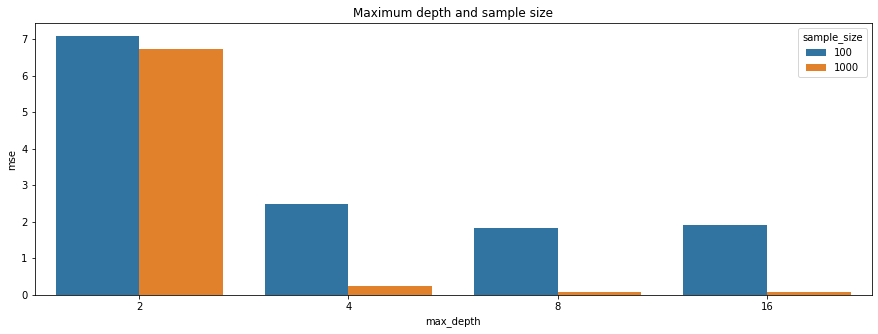

In [ ]:
fig_depth_size = sns.barplot(data=max_depth_df[["mse", "max_depth", "sample_size"]], x="max_depth", y="mse", hue="sample_size")
fig_depth_size.set_title("Maximum depth and sample size")

## Number of estimators


If a reasonable maximum tree depth is allowed, increasing the number of estimators will also improve the performance of the random forest.

### Experiments

In [ ]:
estimators_df = []
for n_estimators in [10, 100]:
  for curr_max_depth in [16]:
    for sample_size in [1000]:
      metadata = dict(max_depth=curr_max_depth, n_estimators=n_estimators)
      get_random_forest = lambda: RandomForest(**metadata)
      output = test_model(get_random_forest, data, metadata, train_split="train+dev", test_split="test", dataset="raw", sample=sample_size)
      row = output["metrics"]
      row.update({"max_depth": curr_max_depth, "sample_size": sample_size, "n_estimators": n_estimators})
      estimators_df.append(row)

estimators_df = pd.DataFrame(estimators_df)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
estimators_df

,mse,pearson,max_depth,sample_size,n_estimators
0,0.070864,0.999553,16,1000,10
1,0.079844,0.999464,16,1000,100


In [ ]:
print(estimators_df.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &       mse &   pearson &  max\_depth &  sample\_size &  n\_estimators \\
\midrule
0 &  0.070864 &  0.999553 &         16 &         1000 &            10 \\
1 &  0.079844 &  0.999464 &         16 &         1000 &           100 \\
\bottomrule
\end{tabular}



### Plot

Text(0.5, 1.0, 'Number of estimators (max_depth = 16, sample_size=1000)')

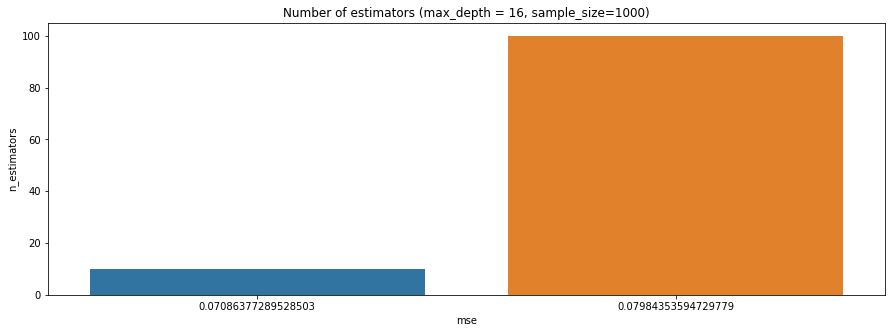

In [ ]:
fig_estimators = sns.barplot(data=estimators_df[["mse", "n_estimators"]].astype(float), x="mse", y="n_estimators")
fig_estimators.set_title("Number of estimators (max_depth = 16, sample_size=1000)")

# Model Comparison with `sklearn`

Let's try to make a fair comparison between our implementation and the random forest implemented by `sklearn`.

We evaluate both models on our test set using the best parameters found during hyperparameter search on our model.

`sklearn` was able to reach a mean-squared error of **0.02** , while our model was able to reach an MSE of **0.084**.

It is also possible to see from the visualizations that predictions from both models bear a close resemblance to the original data.

In [ ]:
metadata = dict(max_depth=16, n_estimators=100)
get_random_forest = lambda: RandomForest(**metadata)
output = test_model(get_random_forest, data, metadata, train_split="train+dev", test_split="test", dataset="raw", sample=1000)

  0%|          | 0/100 [00:00<?, ?it/s]

### Visualization: our model

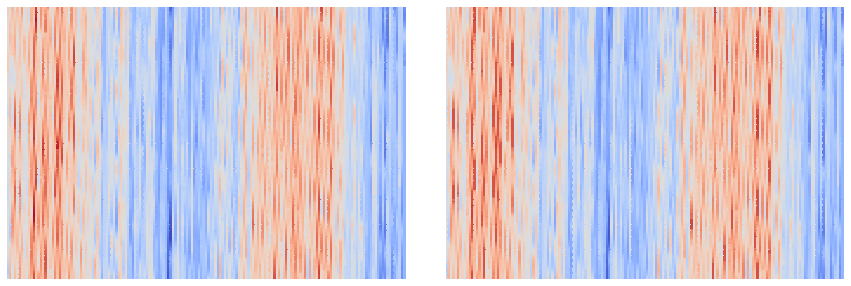

In [ ]:
plot_results(output)

In [ ]:
metadata = dict(max_depth=16, random_state=0, n_estimators = 100, n_jobs=-1)
get_random_forest = lambda: RandomForestRegressor(**metadata)
third_party_output = test_model(get_random_forest, data, metadata, train_split="train+dev", test_split="test", dataset="raw", sample=1000)

### Visualization: `sklearn`

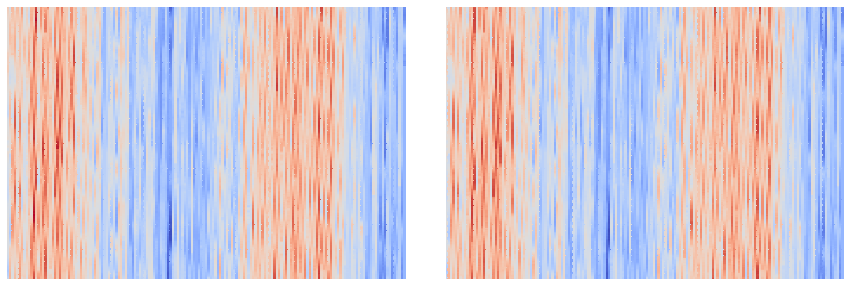

In [ ]:
plot_results(third_party_output)

### Metrics

In [ ]:
third_party_output["metrics"]

{'mse': 0.020085831126976927, 'pearson': 0.9998507641833597}

In [ ]:
output["metrics"]

{'mse': 0.08401276870158644, 'pearson': 0.9994452120239466}

# Conclusions


Our analysis showed that feature selection can effectively reduce the dimensionality of the input data without significantly impacting model performance, especially if the dropped features are redundant. However, PCA had a significant negative impact on the mean squared error of the model predictions.

Our implementation of random forests outperformed the `sklearn` library at shallow tree depths, but performed worse when deeper trees were allowed. This may be due to the complex optimizations implemented in `sklearn`. Overall, our results matched the quality of third-party libraries.

The maximum tree depth and the number of estimators are the most important hyperparameters for determining the performance of a random forest. It is recommended to experiment with these hyperparameters to optimize model performance.